In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
from torch.optim import lr_scheduler
import torch.optim as optim
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [2]:
#Batch size
batch_size=128
#Epoch 
num_epochs=3
#learning rate
learning_rate=0.001

In [3]:
# 데이터 전처리
data_transforms = {
    'train': transforms.Compose([
        # augumentation을 먼저 한 후 totensor와 normalize를 진행해야 한다
        transforms.RandomResizedCrop(224), # data augumentation
        transforms.RandomHorizontalFlip(), # data augumentation
        transforms.ToTensor(),
        # .Normalize([mean1, mean2, mean3], [std1, std2, std3])
        # 각 채널을 mean과 std를 사용해 normalize해준다. 각 값들이 (X - mean) / std 로 채널별로 변경된다
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

train_set=torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=data_transforms['train'])
test_set =torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=data_transforms['val'])

dataloaders=dict()
dataloaders['train']= torch.utils.data.DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
dataloaders['val']= torch.utils.data.DataLoader(dataset=test_set, batch_size=batch_size, shuffle=False)

dataset_sizes = {x: len(dataloaders[x].dataset) for x in ['train', 'val']}

print("train 개수",dataset_sizes['train'])
print("test 개수",dataset_sizes['val'])

class_names = train_set.classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print("class_names:",class_names)
print(device)


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
train 개수 50000
test 개수 10000
class_names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
cpu


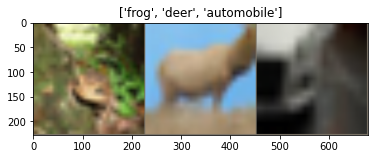

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data. iteration과 next를 사용해 일부만을 불필요한 메모리를 사용하지 않고 불러오도록 하였다
inputs, classes = next(iter(dataloaders['train']))
#batch가 너무 크면 다 안보이니 3개만 가져오기
inputs_=inputs[:3]
classes_=classes[:3]

# Make a grid from batch
out = torchvision.utils.make_grid(inputs_)

imshow(out, title=[class_names[x] for x in classes_])

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict()) # model의 가장 좋은 성능을 보일 때의 학습된 weights를 저장하기 위한 목적
    best_acc = 0.0

    train_loss_list=[]
    val_acc_list=[]

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            iteration_count=0
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                iteration_count+=len(inputs)
                print('Iteration {}/{}'.format(iteration_count,dataset_sizes[phase]))
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    # https://discuss.pytorch.org/t/vgg-output-layer-no-softmax/9273
                    # 단순한 수치의 대소 비교만으로도 Classfication은 가능하며, Softmax의 적용이 어떤 분류에 속하는지를 결과를 바꾸지 않는다.
                    # 따라서 preds를 계산할 때, 즉 Training 과정에서 Prediction을 진행할 때 Softmax를 스킵하여 계산을 줄일 수 있다
                    # Softmax는 Inference 과정에서 분류 Prediction 결과를 확률적으로 이를 나타내기 위해 사용하도록 할 수 있다
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels) # Loss를 계산하는 경우에 CrossEntropyLoss()를 사용하면 내부적으로 Softmax를 output에 적용시킨다.
                    # cf) binary cross entropy loss를 사용할 경우는 명시적으로 이를 추가해야한다

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            if phase=="train":
                train_loss_list.append(epoch_loss)
            elif phase=="val":
                val_acc_list.append(epoch_acc)


            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model,train_loss_list,val_acc_list

In [5]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [7]:
model_ft = models.vgg16(pretrained=True) # torchvision.models에서 제공
num_ftrs = model_ft.classifier[6].in_features # num_ftrs: 4096 (vgg16 FC Layer(Classifier) 7번째 레이어 feature 수)
# 기본적으로 models.vgg16을 불러올 경우, FC Layer의 마지막 output class 수가 1000으로 되어있다(ImageNet 기준으로 작성되었으므로)
# 따라서 우리가 원하는 Class의 수로 다시 맞춰주는 과정이다
model_ft.classifier[6] = nn.Linear(num_ftrs, len(class_names)) # 새로운 리니어 레이어로 재설정(4096, 10)
model_ft = model_ft.to(device) # CPU or GPU
print(model_ft)

criterion = nn.CrossEntropyLoss() # Loss function 설정. CrossEntropyLoss() 내부적으로 Softmax로 적용하여 Loss를 계산한다

# Observe that all parameters are being optimized
#SGD
optimizer_ft = optim.SGD(model_ft.parameters(), lr=learning_rate, momentum=0.9)
#Adam
# optimizer_ft = optim.Adam(model_ft.parameters(), lr=learning_rate)

# Decay LR by a factor of 0.1(gamma) every 7 epochs. lr * gamma for every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/hanoul/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
model_ft,train_loss_list,val_acc_list = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=num_epochs)

Epoch 0/2
----------
Iteration 128/50000


In [ ]:
#plot train loss 
x=[i for i in range(0,num_epochs)]
plt.title("Train Loss")
plt.xticks(x)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(x,train_loss_list)
plt.show()

#plot test acc
x=[i for i in range(0,num_epochs)]
plt.title("Test Accuracy")
plt.xticks(x)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(x,val_acc_list)
plt.show()

In [ ]:
visualize_model(model_ft)